# "You can't classify with linear regression"

* [Or can you?](#or-can-you)
    * [What defines a Linear Regression and a Logistic Regression](#what-defines-a-linear-regression-and-a-logistic-regression)
    * [A classifier using a machine learning regression algorithm](#a-classifier-using-a-regression-model)
* ["But you lose the probabilities that the Logistic Regression will output for you"](#but-you-lose-the-probabilities-that-the-logistic-regression-will-output-for-you)
    * [What probabilities](#what-probabilities)

## Or can you?

### What defines a Linear Regression and a Logistic Regression

Linear Regression can be defined as:
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

Logistic Regression can be defined as:

$$ Pr(y_i = K | X_i) = \frac{1}{1 + \exp^{(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}} $$

Probably it is too small on your screen for you to read what is in the $exp$ term, so let me make it bigger for your display with the power of the natural logarithm:

$$ \ln{(\exp^{(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)})} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$

Strikingly similar to the linear regression, right? The Logistic Regression can be viewed as _just a trick_ on top of the Linear Regression (we can go a bit further and say almost all classifiers are tricks on top of some regression)

In [1]:
import altair as alt
import numpy as np
from crepes import WrapClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from utils.charts import display_static_altair_images
from utils.dataframes import make_classification_df

### Data

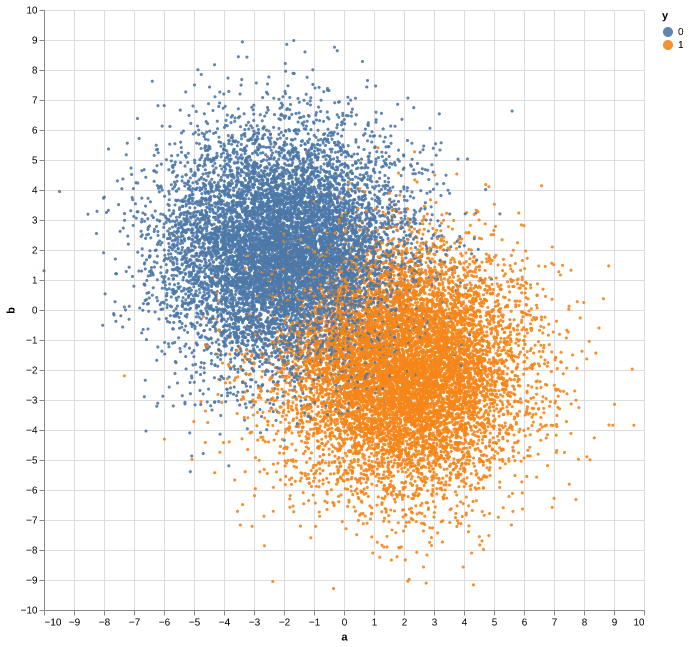

In [2]:
features = ["a", "b"]
target = "y"

df_params = {
    "n_samples": [10000, 10000],
    "features": features,
    "centers": [(-2, 2), (2, -2)],
    "cluster_std": [2, 2],
    "custom_targets": [0, 1],
}


df = make_classification_df(**df_params)

chart = (
    alt.Chart(df)
    .mark_point(size=10, opacity=0.9, filled=True)
    .encode(
        alt.X("a:Q").scale(domain=[-10, 10], clamp=True),
        alt.Y("b:Q").scale(domain=[-10, 10], clamp=True),
        alt.Color("y:N"),
    )
    .properties(
        width=600,
        height=600,
    )
)


display_static_altair_images(chart)

In [3]:
X, y = df.filter(features), df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=0
)

### Linear Regression Classifier

In [4]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_preds = [1 if i > 0.5 else 0 for i in lin_reg.predict(X_test)]
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1969
           1       0.93      0.93      0.93      2031

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



### Logistic Regression Classifier

In [5]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_preds = log_reg.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1969
           1       0.93      0.93      0.93      2031

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



### A classifier using a machine learning regression algorithm

As you can see from the examples above, it is perfectly possible to assign a decision rule on top of a Linear Regression without the _Logistic Regression trick_ to make a classifier.

It is obvious if you consider the fact that the math behind the transformation that exists in the Logistic Regression function preserves the ordering of the results.

## "But you lose the probabilities that the Logistic Regression will output for you"

### What probabilities?

Many algorithms outputs scores that many machine learning practitioners naively interprets as "probabilites".

This happens because in classical statistics the traditional regression analysis for inference requires validation of a set of assumptions to use the selected statistical model. As long all hypothesis are valid for that statistical model, you can confidently says that the outputs are valids probabilities, the estimated parameters can be trusted, etc.

However, machine learning is mainly focused on prediction. For predictions tasks, this means you do not really need to validate the hypothesis, as long you can measure model against a test set and validate its predictive performance. The predictive performance dos not directly depends on having true probabilities.

Even so, for many high risk settings you need to quantify the uncertainty of any decision based on calibrated probabilites. This gave rise to many calibration methods, class balancing, etc that does not solves the real problem here: not all [sets of measure 1](https://en.wikipedia.org/wiki/Probability_measure) are probabilities just because all scores fit nicely into $[0, 1]$. They are only valid if assumptions are met or if you actually measure it.

By applying a proper uncertainty quantification on top of your results, you can get valid probabilities that you can trust.

In [6]:
def scaling(*args, **kwargs):
    X = lin_reg.predict(X_test)
    result = np.zeros((len(X_test), 2))
    result[:, 1] = X
    result[:, 0] = 1 - result[:, 1]
    return result


lin_reg.predict_proba = scaling
lin_reg.classes_ = np.array([0, 1])

conformal_classifier = WrapClassifier(lin_reg)
conformal_classifier.calibrate(X_calib, y_calib.to_numpy())
sets = conformal_classifier.predict_set(X_test, confidence=0.95)

sum(sets)

array([3808, 3797])

In [7]:
conformal_classifier = WrapClassifier(log_reg)
conformal_classifier.calibrate(X_calib, y_calib.to_numpy())
sets = conformal_classifier.predict_set(X_test, confidence=0.95)
sum(sets)

array([2127, 2168])

As we can see, the calibrated probabilities of a logistic regression classifier are way better computed than the ones of the linear regression alone.

Do you know why? What we call a "machine learning model" is actually composed in many cases of at least two pieces, three if we are working with classification:
 * the _model for the parameters_, that can be something like a classic regression model or a tree based model (a tree-based classifier also outputs scores that ranges from $ (-\infty, \infty) $);
 * the _optimization algorithm_, that reduces the error of your model throughout the many iterations;
 * if it is a classifier, a decision rule.

The main difference between the sklearn implementation of the [Logistic Regression Classifier](#logistic-regression-classifier) and our custom [Linear Regression Classifier](#linear-regression-classifier) is that the former uses a proper optimization algorithm for classification tasks based on [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) while the latter uses [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error).

See? It isn't in the model part that the difference between regression and classification tasks occurs in machine learning. Actually, it emerges from everything else after the core model of the algorithm and this is the reason you wouldn't classify with regression alone. But you do use regression in classification tasks. It is just that the whole sklearn implementation is geared towards predefined use cases.